# 0. Import needed libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook")

# 1. Exploratory Data Analysis (EDA)

## 1.1 Read data from the given file

Dataset source: [HR Analytics: Job Change of Data Scientists](https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists)

In [2]:
file_path = '../data/raw/aug_train.csv' 

data = np.genfromtxt(
    file_path,
    delimiter=',',
    skip_header=1,    # Skip header row
    dtype=str         # Load as strings (no preprocessing)
)

data[:5]

array([['8949', 'city_103', '0.92', 'Male', 'Has relevent experience',
        'no_enrollment', 'Graduate', 'STEM', '>20', '', '', '1', '36',
        '1.0'],
       ['29725', 'city_40', '0.7759999999999999', 'Male',
        'No relevent experience', 'no_enrollment', 'Graduate', 'STEM',
        '15', '50-99', 'Pvt Ltd', '>4', '47', '0.0'],
       ['11561', 'city_21', '0.624', '', 'No relevent experience',
        'Full time course', 'Graduate', 'STEM', '5', '', '', 'never',
        '83', '0.0'],
       ['33241', 'city_115', '0.789', '', 'No relevent experience', '',
        'Graduate', 'Business Degree', '<1', '', 'Pvt Ltd', 'never',
        '52', '1.0'],
       ['666', 'city_162', '0.767', 'Male', 'Has relevent experience',
        'no_enrollment', 'Masters', 'STEM', '>20', '50-99',
        'Funded Startup', '4', '8', '0.0']], dtype='<U23')

In [3]:
with open(file_path, "r", encoding='utf-8') as file:
    columns = file.readline().split(",")
columns = [item.strip() for item in columns if item.strip()]
columns

['enrollee_id',
 'city',
 'city_development_index',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job',
 'training_hours',
 'target']

## 1.2 Meaning of each column

| Feature | Description |
| --- | --- |
| `enrollee_id` | Unique ID for candidate. |
| `city` | City code. |
| `city_development_index` | Development index of the city (scaled). |
| `gender` | Gender of candidate. |
| `relevent_experience` | Relevant experience of candidate. (Has/No relevent experience) |
| `enrolled_university` | Type of University course enrolled, if any. |
| `education_level` | Education level of candidate. |
| `major_discipline` | Education major discipline of candidate. |
| `experience` | Candidate total experience in years. |
| `company_size` | Number of employees in current employer's company. |
| `company_type` | Type of current employer. |
| `last_new_job` | Years between previous job and current job. |
| `training_hours` | Training hours completed. |
| `target` | 0 – Not looking for job change; 1 – Looking for a job change. |

## 1.3 Helper utilities

In [21]:
col_idx = {c: i for i, c in enumerate(columns)}
col_arrays = {c: data[:, i] for c, i in col_idx.items()}

print(col_idx)

{'enrollee_id': 0, 'city': 1, 'city_development_index': 2, 'gender': 3, 'relevent_experience': 4, 'enrolled_university': 5, 'education_level': 6, 'major_discipline': 7, 'experience': 8, 'company_size': 9, 'company_type': 10, 'last_new_job': 11, 'training_hours': 12, 'target': 13}


In [5]:
for key, value in col_arrays.items():
    print("Key", key)
    print("Value:", value[:5])
    print("-" * 20)


Key enrollee_id
Value: ['8949' '29725' '11561' '33241' '666']
--------------------
Key city
Value: ['city_103' 'city_40' 'city_21' 'city_115' 'city_162']
--------------------
Key city_development_index
Value: ['0.92' '0.7759999999999999' '0.624' '0.789' '0.767']
--------------------
Key gender
Value: ['Male' 'Male' '' '' 'Male']
--------------------
Key relevent_experience
Value: ['Has relevent experience' 'No relevent experience'
 'No relevent experience' 'No relevent experience'
 'Has relevent experience']
--------------------
Key enrolled_university
Value: ['no_enrollment' 'no_enrollment' 'Full time course' '' 'no_enrollment']
--------------------
Key education_level
Value: ['Graduate' 'Graduate' 'Graduate' 'Graduate' 'Masters']
--------------------
Key major_discipline
Value: ['STEM' 'STEM' 'STEM' 'Business Degree' 'STEM']
--------------------
Key experience
Value: ['>20' '15' '5' '<1' '>20']
--------------------
Key company_size
Value: ['' '50-99' '' '' '50-99']
------------------

In [6]:
# Pretty table rendering from col_arrays

def print_table_from_col_arrays(col_arrays, columns, cols=None, limit=10, max_width=18):
    cols = columns if cols is None else cols
    if not col_arrays:
        print("col_arrays is empty")
        return
    n = len(next(iter(col_arrays.values())))
    k = min(limit, n)

    def _trunc(s):
        s = str(s)
        return s if len(s) <= max_width else (s[: max_width - 3] + "...")

    trunc_vec = np.vectorize(_trunc)

    values_per_col = {}
    widths = []
    for c in cols:
        vals = col_arrays[c][:k].astype(str)
        vals = trunc_vec(vals)
        w = int(max([len(c)] + [len(v) for v in vals.tolist()]))
        widths.append(w)
        values_per_col[c] = vals

    header = " | ".join([f"{c:<{w}}" for c, w in zip(cols, widths)])
    sep = "-+-".join(["-" * w for w in widths])
    print(header)
    print(sep)
    for i in range(k):
        row = " | ".join([f"{values_per_col[c][i]:<{w}}" for c, w in zip(cols, widths)])
        print(row)
    if k < n:
        print(f"... ({n - k} more rows)")


In [7]:


def _is_float(s):
    try:
        float(s)
        return True
    except Exception:
        return False

safe_float_vec = np.vectorize(lambda x: float(x) if _is_float(str(x).strip()) else np.nan)

# Missing mask helper
_missing_tokens = np.array(['', 'na', 'nan', 'null', 'none', '?'], dtype='<U5')


def missing_mask(arr):
    s = np.char.lower(np.char.strip(arr.astype(str)))
    return (s == '') | np.isin(s, _missing_tokens)


# Experience binning helper: maps raw tokens to 3-year bins
# Bins: <1, 1-3, 4-6, 7-9, 10-12, 13-15, 16-18, 19-20, >20

def map_exp_bin(s):
    t = str(s).strip().lower()
    if t == '' or t in _missing_tokens:
        return None

    # Handle common textual forms
    if t in ('<1', '< 1', 'less than 1', 'less than1', 'fresher'):
        return '<1'
    if t in ('>20', '> 20', 'more than 20', 'more than20'):
        return '>20'

    # Extract numeric part
    digits = ''.join(ch for ch in t if ch.isdigit())
    if digits == '':
        return None

    try:
        x = int(digits)
    except Exception:
        return None

    if x < 1:
        return '<1'
    if 1 <= x <= 3:
        return '1-3'
    if 4 <= x <= 6:
        return '4-6'
    if 7 <= x <= 9:
        return '7-9'
    if 10 <= x <= 12:
        return '10-12'
    if 13 <= x <= 15:
        return '13-15'
    if 16 <= x <= 18:
        return '16-18'
    if 19 <= x <= 20:
        return '19-20'
    if x > 20:
        return '>20'
    return None


### Detect which columns are numeric or categorical

In [8]:
# Detect numeric vs categorical
numeric_cols, categorical_cols, numeric_data = [], [], {}
for name, arr in col_arrays.items():
    nums = safe_float_vec(arr)
    non_nan_ratio = np.mean(~np.isnan(nums))
    if non_nan_ratio > 0.8:  # mostly numeric -> treat as numeric
        numeric_cols.append(name)
        numeric_data[name] = nums
    else:
        categorical_cols.append(name)

print('Detected numeric columns:', numeric_cols)
print('Detected categorical columns:', categorical_cols)

Detected numeric columns: ['enrollee_id', 'city_development_index', 'training_hours', 'target']
Detected categorical columns: ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']


In [9]:
print_table_from_col_arrays(col_arrays, columns, limit=11)

enrollee_id | city     | city_development_index | gender | relevent_experience | enrolled_university | education_level | major_discipline | experience | company_size | company_type   | last_new_job | training_hours | target
------------+----------+------------------------+--------+---------------------+---------------------+-----------------+------------------+------------+--------------+----------------+--------------+----------------+-------
8949        | city_103 | 0.92                   | Male   | Has relevent ex...  | no_enrollment       | Graduate        | STEM             | >20        |              |                | 1            | 36             | 1.0   
29725       | city_40  | 0.7759999999999999     | Male   | No relevent exp...  | no_enrollment       | Graduate        | STEM             | 15         | 50-99        | Pvt Ltd        | >4           | 47             | 0.0   
11561       | city_21  | 0.624                  |        | No relevent exp...  | Full time course    | G

## 1.4 Dataset overview

### 1.4.1 Number of missing values in each column and its percentage

In [10]:
# Overview: shape, missing values, and type summary
n_rows, n_cols = data.shape
print(f"Rows: {n_rows}, Columns: {n_cols}")

# Missing per column
missing_stats = []
for col in columns:
    arr = col_arrays[col]
    m = missing_mask(arr)
    missing_stats.append((col, int(m.sum()), float(m.mean())))

missing_stats_sorted = sorted(missing_stats, key=lambda x: x[1], reverse=True)
print("\nTop missing columns:")
for col, cnt, rate in missing_stats_sorted:
    print(f"- {col}: {cnt} ({rate:.4%})")

print("\nType summary:")
print(f"Numeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")

Rows: 19158, Columns: 14

Top missing columns:
- company_type: 6140 (32.0493%)
- company_size: 5938 (30.9949%)
- gender: 4508 (23.5306%)
- major_discipline: 2813 (14.6832%)
- education_level: 460 (2.4011%)
- last_new_job: 423 (2.2080%)
- enrolled_university: 386 (2.0148%)
- experience: 65 (0.3393%)
- enrollee_id: 0 (0.0000%)
- city: 0 (0.0000%)
- city_development_index: 0 (0.0000%)
- relevent_experience: 0 (0.0000%)
- training_hours: 0 (0.0000%)
- target: 0 (0.0000%)

Type summary:
Numeric columns (4): ['enrollee_id', 'city_development_index', 'training_hours', 'target']
Categorical columns (10): ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']


#### Insights

`company_type` has  32.0% of missing \
`company_size` has 31.0% of missing

These two columns are literally missing in 1 out of every 3 rows.

- This amount of missingness suggests:

    - Many candidates did not report their company info, possibly because

        - they were unemployed

        - they had no prior company experience

        - they preferred not to disclose

    - These features may still be useful, but require robust imputation.

`gender:`

- Many candidates intentionally did not report gender, we should treat missing as a separate category.

- Gender is important but sensitive. Missingness may be meaningful.

`major_discipline:`
- Missing likely corresponds to non-STEM degrees.

### 1.4.2 Numeric distributions and correlations

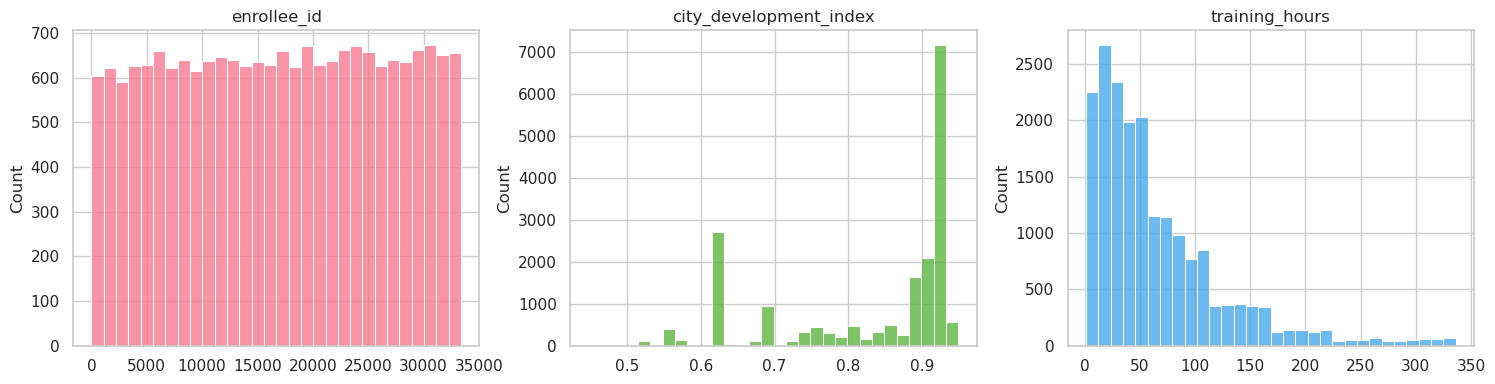

In [11]:
# Histograms for up to 4 numeric features
num_to_plot = len(numeric_cols) - 1

if num_to_plot > 0:
    palette = sns.color_palette("husl", num_to_plot)

    ncols = 3
    nrows = (num_to_plot + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4 * nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(numeric_cols[:num_to_plot]):
        x = numeric_data[col]
        x = x[~np.isnan(x)]

        color = palette[i]

        sns.histplot(x, bins=30, ax=axes[i], kde=False, color=color)
        axes[i].set_title(col)

    for j in range(i + 1, nrows * ncols):
        axes[j].axis('off')

    plt.tight_layout()

else:
    print("No numeric columns detected for histogram plotting.")


- `enrollee_id`: 
    - The distribution is uniform across the entire range.
    - It's just an indentifier, and doesn't have any meaningful value, so we can drop it when used to train model.
- `city_development_index`:
    - The distribution is right-skewed, with most values concentrated between 0.80 – 0.95.
    - A large majority of candidates come from high-development cities.
    - There's a kinda medium number of employees come from are **0.62**, this could be a potential part to explore.
    - Insights:
        - People from well-developed cities dominate the dataset.
- `training_hours`:
    - Insights:
        - Training hours vary widely -> could strongly correlate with job change.
        - Heavy learners (100+ hours) may be:
            - Actively preparing to switch jobs.
            - upgrading skills for better opportunities.
    - We should apply **log transform** to reduce skewness.


### 1.4.3 Categorical distributions (top 10 categories)

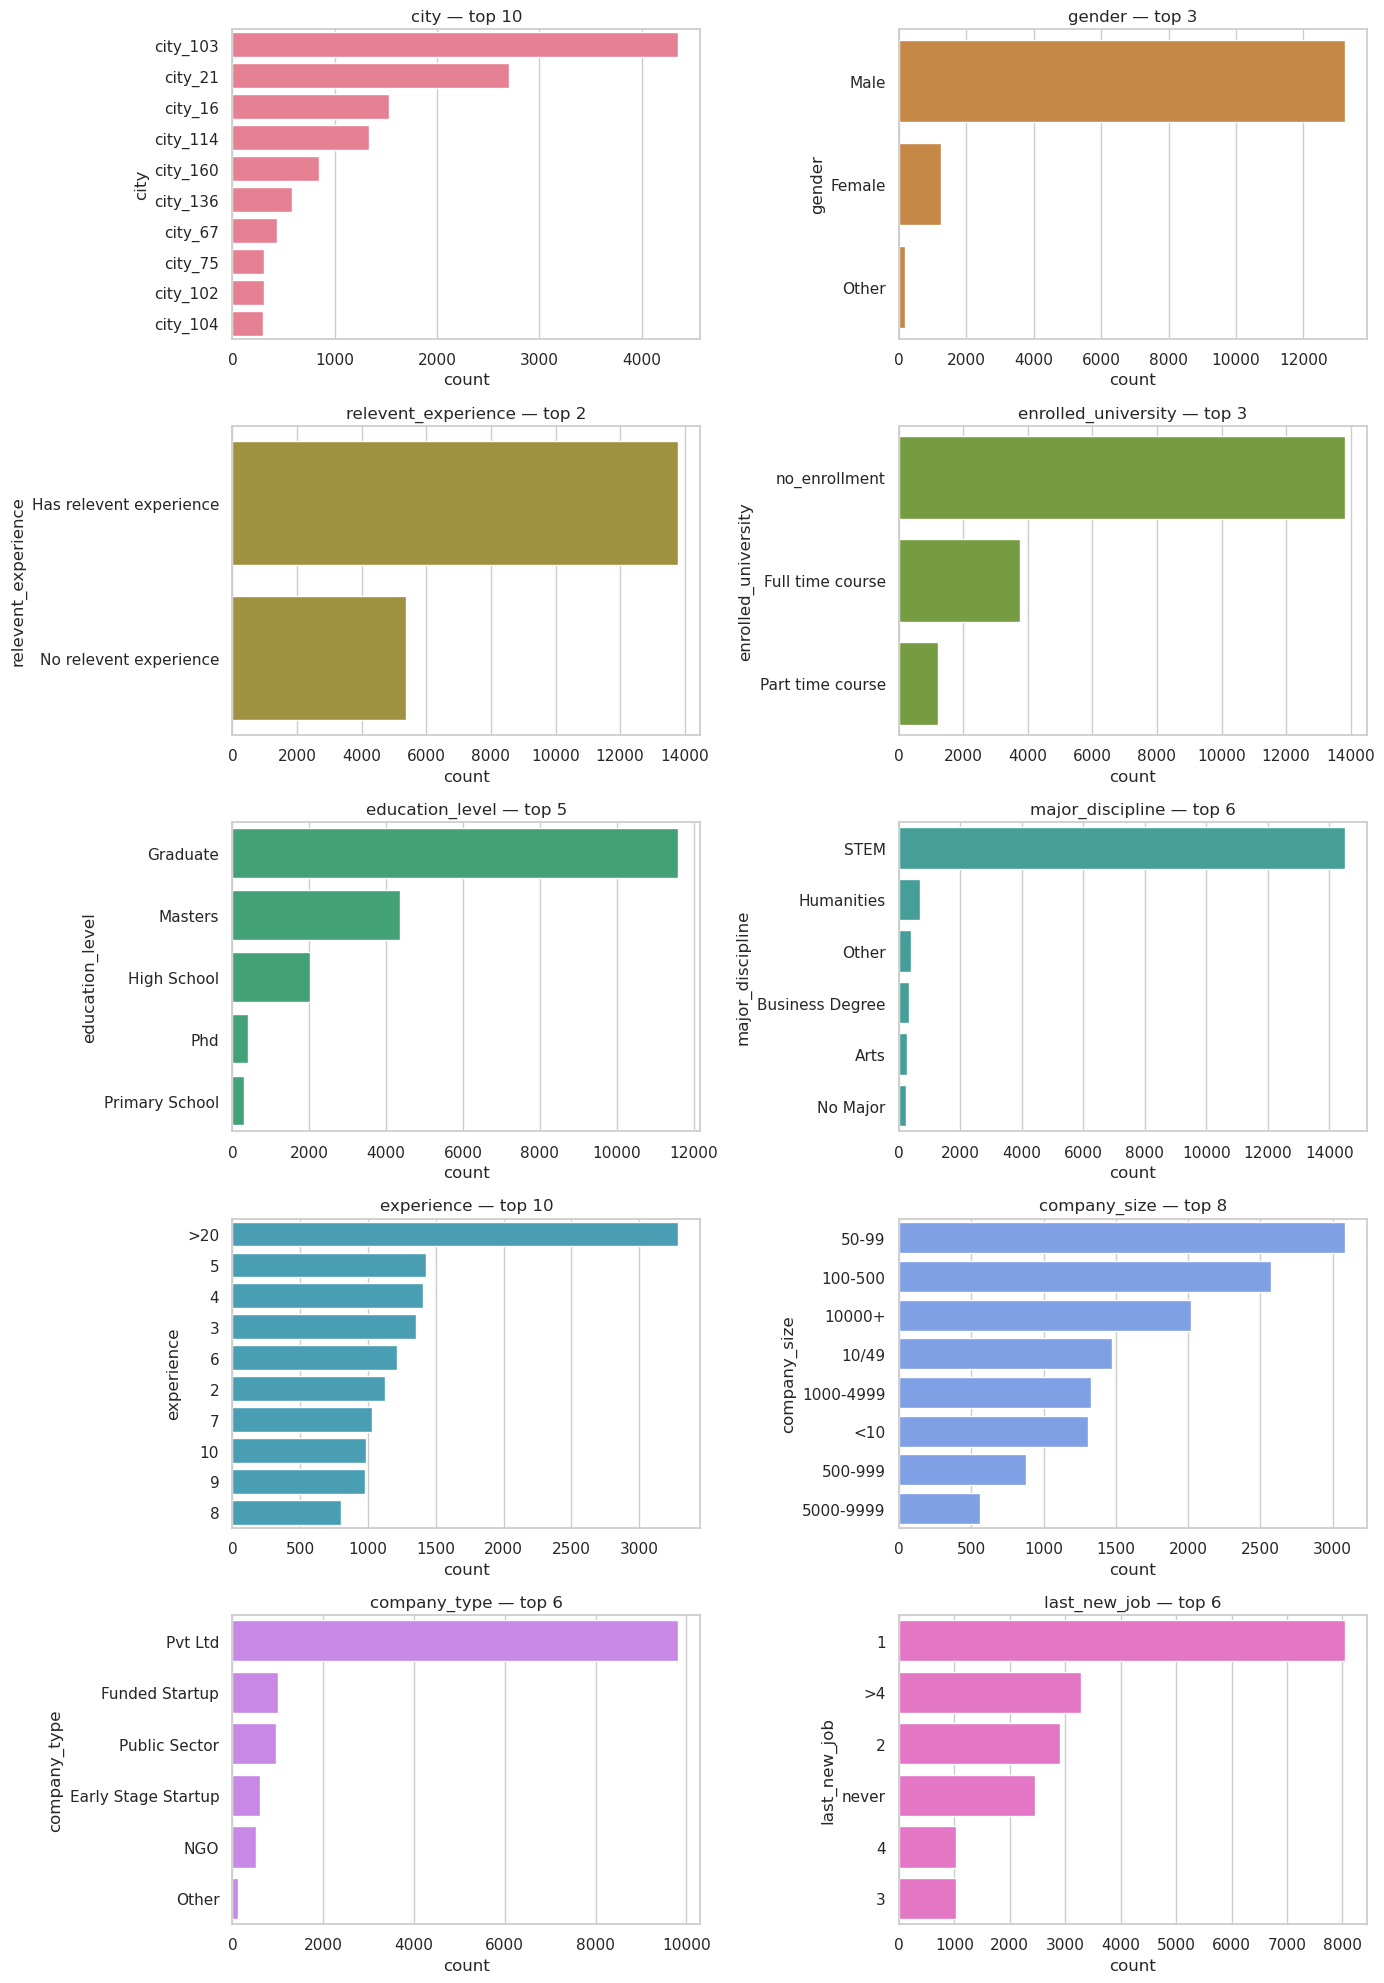

In [12]:
palette = sns.color_palette("husl", len(categorical_cols))

cat_to_plot = len(categorical_cols)
if cat_to_plot > 0:
    ncols = 2
    nrows = (cat_to_plot + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4 * nrows))
    axes = np.atleast_1d(axes).ravel()

    def top_categories(arr, k=10):
        s = np.char.strip(arr.astype(str))
        mask = (s != '') & (~np.isin(np.char.lower(s), _missing_tokens))
        vals, counts = np.unique(s[mask], return_counts=True)
        order = np.argsort(counts)[::-1]
        return vals[order][:k], counts[order][:k]

    for i, col in enumerate(categorical_cols[:cat_to_plot]):
        vals, counts = top_categories(col_arrays[col], k=10)

        color = palette[i]

        sns.barplot(x=counts, y=vals, orient='h', ax=axes[i], color=color)
        axes[i].set_title(f"{col} — top {len(vals)}")
        axes[i].set_xlabel('count')
        axes[i].set_ylabel(col)

    for j in range(i + 1, nrows * ncols):
        axes[j].axis('off')

    plt.tight_layout()
else:
    print("No categorical columns detected for bar plots.")

`City`: 
- A few cities dominate (city_103, city_21, city_16).
- Many cities have small counts.
- This means city is a high-cardinality categorical variable.

`Gender`:
- Majority: Male
- Smaller: Female
-> Gender imbalance, this may introduce bias. 

`Relevant Experience` (Very strong imbalance):
- Most people have experience.
- Only a minority have “No experience”.
-> This could be very predictive job of job change/

`Enrolled University` (Most people not studying):
- Highest: No enrollment
- Much smaller: Full-time, Part-time.
-> “Not enrolled in a university” is the majority"
- This may correlate strongly with:
    - experience
    - company size/type
    - last new job

`Education Level`:
- Biggest group: Graduate
- Smaller: Masters, High School, PhD, Primary school.
- Education is mid-skewed, but not extremely.
- Good predictor for job change (higher degrees are less likely to change, usually)

`Major Discipline`:
- STEM is overwhelmingly the largest group.
- Humanities / Business / Arts appear very small.
- STEM vs non-STEM is likely far more predictive than each detailed category.

`Experience`:
- Surprised that most frequent: >20 years 
- Next: 5, 4, 3 years…
- This mean the most of people doing this survey have really long experience

`Company Size`:
- Most frequent: 50–99
- Next: 100–500, 10000+, 10–49, etc.
- Many companies are smaller 
- Company size + company type combined could be strong predictors of job change.

`Company Type`:
- Dominant: Pvt Ltd
- Others categories small.
- We could treat the dataset like **'pvt Ltd'** and **'other'**


`Last New Job`:
- Most frequent: 1 year
- Then: >4, never, 2…
- Many people switched jobs recently.


### 1.4.5 Target distribution

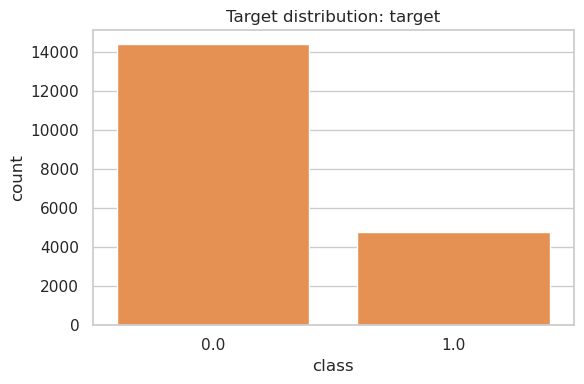

In [ ]:
# Distribution of target and numeric vs target plots
target_name = None
for c in columns:
    if c.lower() == 'target':
        target_name = c
        break

if target_name is None:
    print("No 'target' column found — skipping target analysis.")
else:
    t_raw = col_arrays[target_name]
    t = safe_float_vec(t_raw)
    valid_t = ~np.isnan(t)
    t_valid = t[valid_t]

    # Target distribution
    vals, counts = np.unique(t_valid, return_counts=True)
    plt.figure(figsize=(6, 4))
    sns.barplot(x=vals, y=counts, color='#fd8d3c')
    plt.title(f"Target distribution: {target_name}")
    plt.xlabel('class')
    plt.ylabel('count')
    plt.tight_layout()

We could easily see that the target is imbalanced, so we could use class weights

## 1.5 Questions need to be answered
1. Do men tend to look for a job change than women?
2. Do cities with high development index have higher changing job rate?
3. Which cities have the highest percentage of changing their job, sort these cities from the highest to lowest? 
4. Do higher training time lead to higher switching rate?

### 1.5.1 Do men tend to look for a job change than women?

In [14]:
mask_change_job = (col_arrays["target"].astype(float) == 1.)
mask_male = (col_arrays["gender"] == 'Male')
mask_female= (col_arrays["gender"] == 'Female')

percentate_of_men_looking_for_job = (mask_change_job & mask_male).sum() / mask_male.sum() * 100
percentate_of_women_looking_for_job = (mask_change_job & mask_female).sum() / mask_female.sum() * 100


print(f"Percentage of men looking for job change: {percentate_of_men_looking_for_job:>.2f}%")
print(f"Percentage of women looking for job change: {percentate_of_women_looking_for_job:>.2f}%")

Percentage of men looking for job change: 22.78%
Percentage of women looking for job change: 26.33%


It looks like women tent to look for job change than men

### 1.5.2 Do cities with high development index have higher changing job rate?


In [15]:
# I will split the city development index into 2 bins: ">= 0.8" and "< 0.8"
# then compare its percentage of looking for job change

high_index_mask = (col_arrays["city_development_index"].astype(float) >= 0.8)
low_index_mask = (col_arrays["city_development_index"].astype(float) < 0.8)

# len(col_arrays["city_development_index"]) == high_index_mask.sum() + low_index_mask.sum()

In [16]:
per_of_high_index = (mask_change_job & high_index_mask).sum() / high_index_mask.sum() * 100
per_of_low_index = (mask_change_job & low_index_mask).sum() / low_index_mask.sum() * 100


print(f"Percentage of people in hiw development index cities looking for job change: {per_of_high_index:>.2f}%")
print(f"Percentage of people in low development index cities looking for job change: {per_of_low_index:>.2f}%")

Percentage of people in hiw development index cities looking for job change: 15.96%
Percentage of people in low development index cities looking for job change: 44.79%


Employees in low development index area want to change their job than the high development one

### 1.5.3 Which cities have the highest percentage of changing their job, sort these cities from the highest to lowest? 

In [17]:
city = col_arrays["city"].astype(str)
target = col_arrays["target"].astype(float)

# Valid masks: non-missing city and target in {0,1}
city_mask = (np.char.strip(city) != '')
target_mask = ~np.isnan(target)
valid = city_mask & target_mask

city_valid = city[valid]
target_valid = target[valid]

# Map cities to indices
cities, inv = np.unique(city_valid, return_inverse=True)

# Totals per city
counts = np.bincount(inv)
# Positive counts per city using weights
pos_counts = np.bincount(inv, weights=(target_valid == 1.0).astype(float))

# Percentages
percent = np.where(counts > 0, (pos_counts / counts) * 100.0, np.nan)

# Sort by percentage desc, then by count desc for tie-breaking
order = np.lexsort(((-counts), -percent))

cities_sorted = cities[order]
percent_sorted = percent[order]
counts_sorted = counts[order]

print("City | % change | Number of employees")
print("---- | -------- | ---")
for i in range(len(cities_sorted)):
    print(f"{cities_sorted[i]} | {percent_sorted[i]:5.2f}% | {int(counts_sorted[i])}")


City | % change | Number of employees
---- | -------- | ---
city_171 | 100.00% | 1
city_139 | 80.00% | 5
city_155 | 78.57% | 14
city_42 | 69.23% | 13
city_107 | 66.67% | 6
city_33 | 64.71% | 17
city_179 | 60.00% | 5
city_11 | 59.51% | 247
city_21 | 59.10% | 2702
city_145 | 58.73% | 63
city_43 | 58.33% | 12
city_101 | 57.33% | 75
city_128 | 56.52% | 92
city_48 | 53.85% | 13
city_126 | 53.57% | 28
city_74 | 51.92% | 104
city_78 | 51.61% | 31
city_25 | 50.00% | 4
city_70 | 43.18% | 44
city_143 | 39.02% | 41
city_115 | 38.89% | 54
city_94 | 38.46% | 26
city_19 | 37.82% | 119
city_146 | 37.50% | 8
city_79 | 37.50% | 8
city_91 | 35.56% | 45
city_118 | 33.33% | 27
city_44 | 33.33% | 18
city_106 | 33.33% | 9
city_109 | 33.33% | 9
city_131 | 33.33% | 9
city_121 | 33.33% | 3
city_90 | 31.47% | 197
city_53 | 30.77% | 26
city_117 | 30.77% | 13
city_158 | 30.61% | 49
city_142 | 30.19% | 53
city_167 | 30.00% | 10
city_59 | 30.00% | 10
city_176 | 29.17% | 24
city_84 | 29.17% | 24
city_162 | 28.91% | 

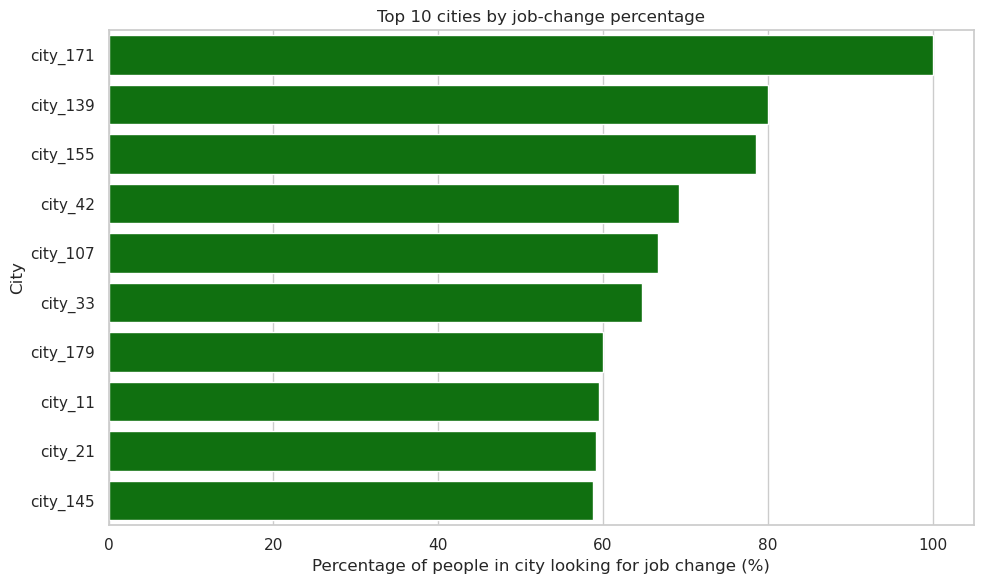

In [18]:
top_k = min(10, len(cities_sorted))
plt.figure(figsize=(10, 6))
sns.barplot(x=percent_sorted[:top_k], y=cities_sorted[:top_k], orient='h', color='green')
plt.xlabel('Percentage of people in city looking for job change (%)')
plt.ylabel('City')
plt.title('Top 10 cities by job-change percentage')
plt.tight_layout()

### 1.5.4 Do higher training time lead to higher switching rate?

In [19]:

train = safe_float_vec(col_arrays["training_hours"])  # numeric with NaNs
target = safe_float_vec(col_arrays["target"])         # 0/1 with NaNs
valid = (~np.isnan(train)) & (~np.isnan(target))

train_v = train[valid]
target_v = target[valid]

# Define bins (hours)
bins = np.array([0, 10, 25, 50, 75, 100, 150, 200, np.max(train_v) + 1])
labels = ["0-9", "10-24", "25-49", "50-74", "75-99", "100-149", "150-199", "200+"]

idx = np.digitize(train_v, bins, right=False) - 1
idx = np.clip(idx, 0, len(labels) - 1)

counts = np.bincount(idx, minlength=len(labels))
pos = np.bincount(idx, weights=(target_v == 1.0).astype(float), minlength=len(labels))
perc = np.where(counts > 0, pos / counts * 100.0, np.nan)

print("Bin | % change | Number of people")
print("--- | -------- | ---")
for i, lab in enumerate(labels):
    print(f"{lab:>6} | {perc[i]:6.2f}% | {int(counts[i])}")


Bin | % change | Number of people
--- | -------- | ---
   0-9 |  25.24% | 1486
 10-24 |  25.09% | 3710
 25-49 |  25.73% | 4718
 50-74 |  25.14% | 3206
 75-99 |  24.45% | 2057
100-149 |  25.06% | 2159
150-199 |  24.17% | 997
  200+ |  20.12% | 825


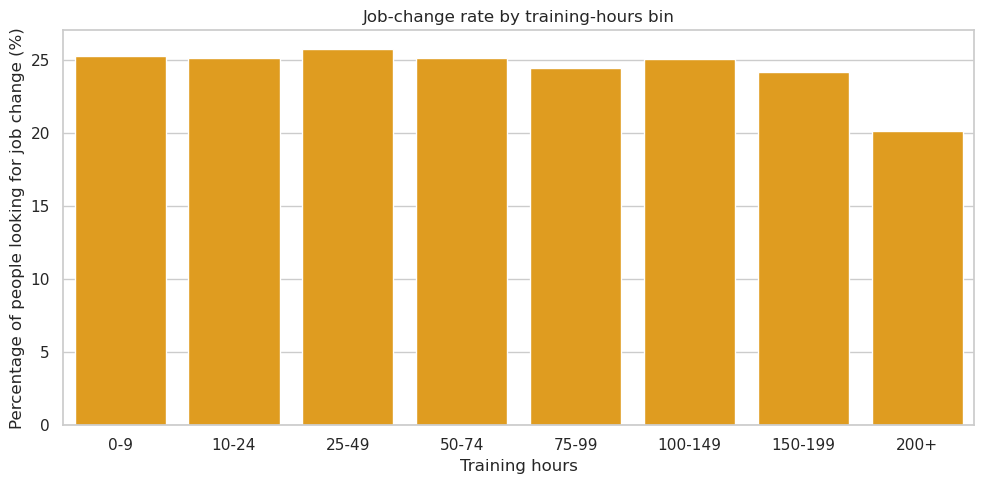

In [20]:
# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=labels, y=perc, color='orange')
plt.ylabel('Percentage of people looking for job change (%)')
plt.xlabel('Training hours')
plt.title('Job-change rate by training-hours bin')
plt.tight_layout()

It seems like there's no diffence of people with long and short training hours, but people with 200+ training hours have smaller percentage of job change 